## 多任务学习（Multi-Task Learning, MTL）
### 1.1多任务学习的必要性

#### 1.1.1 从一个真实产品场景开始

想象你在设计一个内容推荐系统。

这个系统的目标很简单：

> 让用户看到他们“喜欢”的内容。

听起来合理。但问题来了——

**我们如何定义“喜欢”？**

在系统里，喜欢不能被直接观测。
我们只能看到用户的行为，例如：

* 是否点击
* 是否停留
* 是否点赞
* 是否评论
* 是否分享
* 是否关注作者

于是一个自然的工程决策出现了：

> 先选一个最容易衡量的指标作为目标。

比如：

* 点击率（CTR）
* 点赞率
* 完播率
* 停留时间

这就是推荐系统早期常见的做法。

---

#### 1.1.2 单一指标优化的第一轮成功

假设我们选择“点赞率（CTR）”作为核心目标。

我们训练一个模型：


$$
\max P(action \mid user, item)
$$

上线后，数据表现很好：

* 点赞率提升了
* 用户互动次数增加了
* 指标曲线向上

从数据看，系统“成功”了。

但几周后，产品团队开始发现异常：

* 内容变得越来越相似
* 用户反馈“质量下降”
* 用户对产品的黏性下降

为什么？

---

#### 1.1.3 当模型学会“最大化行为”，而不是“最大化满意度”

我们来看两个内容示例：

| 内容   | 特征        | 点赞行为  |
| ---- | --------- | ----- |
| 内容 A | 强烈诱导互动    | 点赞率高  |
| 内容 B | 信息密集、需要思考 | 点赞率中等 |

如果模型只优化点赞率，那么：

$$
score = P(like)
$$

系统会持续强化内容 A。

因为模型不会判断：

* 内容是否真正有价值
* 用户是否长期满意
* 用户是否会因此留存

它只知道：

> 哪些特征会提高点赞概率。

于是，内容生态开始朝“更容易触发点赞”的方向演化。

这是目标函数的必然结果。

---

#### 1.1.4 用户行为其实是多维度表达

我们重新审视一个问题：

> 用户的每个行为，到底在表达什么？

| 行为   | 可能反映的维度  |
| ---- | -------- |
| 停留时间 | 内容吸引力    |
| 点赞   | 正向态度表达   |
| 评论   | 情绪或观点被触发 |
| 收藏   | 长期价值     |
| 分享   | 社交传播价值   |
| 关注   | 对创作者持续兴趣 |

这些行为之间：

* 不是等价的
* 不是完全替代的
* 也不总是同时发生

例如：

* 有些内容看得很久，但不一定点赞
* 有些内容点赞多，但停留时间短
* 有些内容分享多，但评论少

**满意度不是一个维度，而是一个隐变量。**

而单一指标，只是这个隐变量的一个投影。

---

#### 1.1.5 单任务优化的结构性问题

当系统只优化一个行为时，会出现三个结构性现象：

##### ① 内容分布被单一指标牵引

系统会越来越偏向那些“对该指标友好”的内容。

---

##### ② 短期行为优先于长期价值

单一行为通常是短期可观测信号。

但平台真正关心的是：

* 长期留存
* 用户生命周期价值
* 用户信任感

---

##### ③ 指标劫持（Metric Gaming）

当创作者理解系统规则后，会开始围绕该指标进行内容设计。

生态逐渐偏离“真实价值”。

---

#### 1.1.6 问题抽象：我们到底在优化什么？

现在我们可以抽象出核心问题：

用户满意度是一个**不可观测变量**：

$$
Satisfaction = latent\ variable
$$

而我们能观测到的，是多个行为信号：

$$
like, duration, comment, share, follow
$$

如果只用其中一个去近似 Satisfaction：

$$
Satisfaction \approx like
$$

误差会很大。

这就是单任务模型的本质问题。

---

#### 1.1.7 引入多任务学习

如果一个行为无法完整表达满意度，
那更合理的做法是：

> 同时建模多个行为。

于是优化目标从：

$$
\max P(like)
$$

变为：

$$
\max \sum_i w_i P(action_i)
$$

或者更进一步：

* 多个任务共享底层表示
* 每个行为一个输出头
* 联合训练

这就是：

**Multi-Task Learning（多任务学习）**

它的核心思想是：

> 不再假设一个行为代表全部，而是通过多个行为共同逼近隐变量。

---

### 本阶段总结

从真实产品场景出发，我们经历了一个认知过程：

1. 用户满意度不可直接观测
2. 工程上选一个行为做代理
3. 单一指标优化带来结构性偏差
4. 满意度本质是多维信号的综合
5. 因此需要多任务建模



## 1.2 多任务学习实践：MMOE（Ali-CCP）
#### 1.2.1  前言
在这一部分我们将介绍一种多任务学习模型 **MMOE**，并通过 **torch-rechub** 实现多论任务训练
#### 1.2.2 MMOE 理论介绍
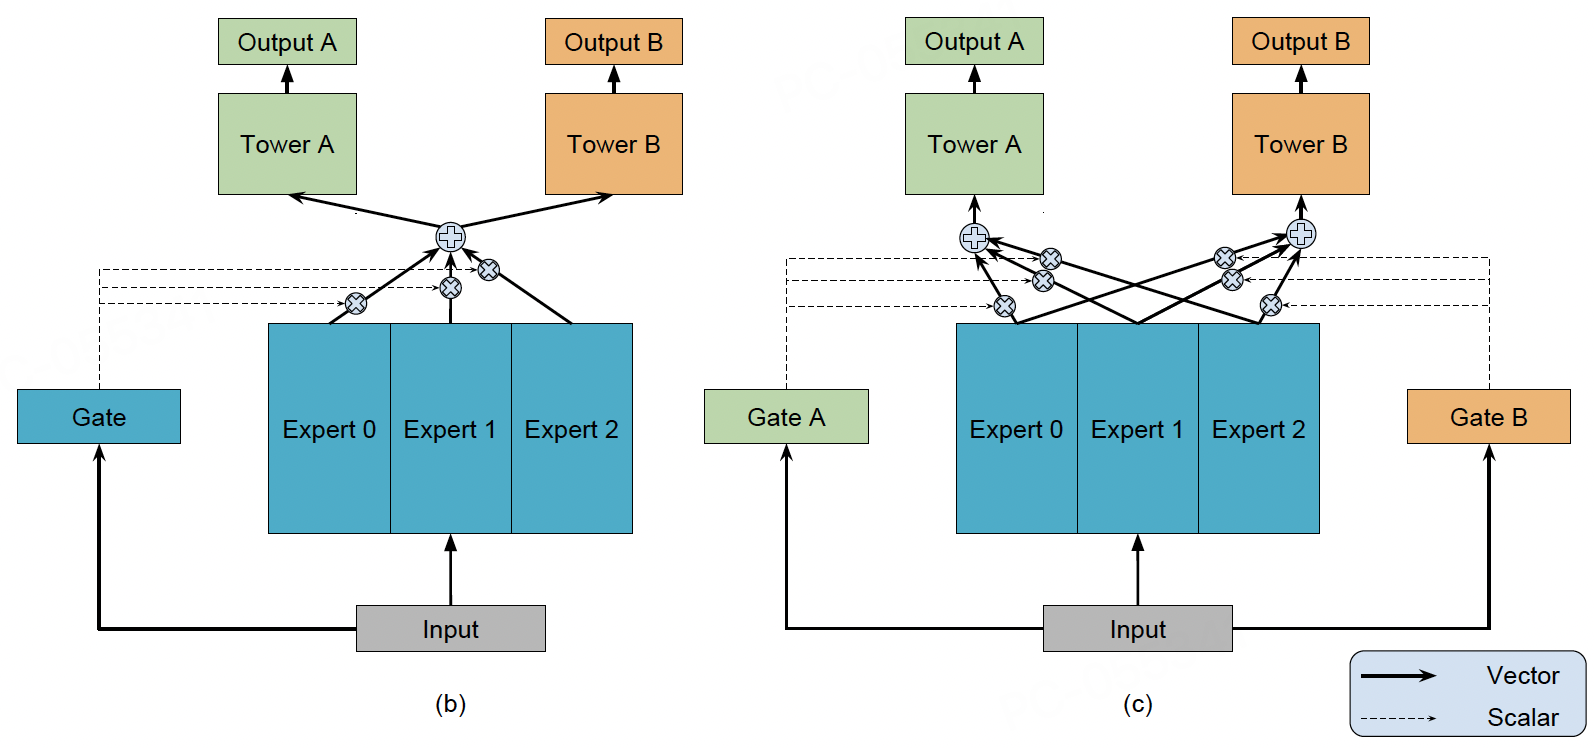
$$\text{MMOE框架图}$$

##### 1.2.3 从图 (b) 到图 (c)：结构差异的本质

图 (b) 展示的是 **单 Gate 的 Mixture-of-Experts（MoE）结构**：

* 所有任务共享同一组 Experts
* 共享同一个 Gate
* 所有任务接收相同的加权专家表示

其计算过程为：

##### ① 专家输出


$$
E_i(x), \quad i=1,\dots,N
$$


##### ② 单一门控权重


$$
g = \text{softmax}(W_g x)
$$


##### ③ 加权组合表示


$$
h = \sum_{i=1}^N g_i E_i(x)
$$


#### ④ 各任务共享该表示


$$
\hat{y}_k = f_k(h)
$$


问题在于：

> 所有任务被迫使用同一个专家组合。

这等价于：


$$
h_1 = h_2 = \dots = h_K
$$


当任务间存在差异时，这种强共享会导致负迁移。

---

#### 1.2.4 MMoE 的核心思想

图 (c) 展示的是 **Multi-gate MoE（MMoE）结构**。

核心改动：

> 为每个任务引入独立 Gate。

专家仍然共享，但门控不再共享。

这实现了：

* 参数共享（Experts）
* 表示选择差异化（Task-specific Gate）

---

#### 1.2.5 MMoE 的数学表达

设：

* 输入特征：( x )
* 专家数量：( N )
* 任务数量：( K )

---

##### Step 1：专家层

所有任务共享 N 个专家：


$$
E_i(x), \quad i=1,\dots,N
$$


每个专家通常是一个多层感知机（MLP）：


$$
E_i(x) = \sigma(W_i x + b_i)
$$


---

##### Step 2：任务专属 Gate

对于第 k 个任务：

$$
g^{(k)} = \text{softmax}(W_g^{(k)} x)
$$

其中：

$$
g^{(k)} \in \mathbb{R}^N, \quad \sum_i g^{(k)}_i = 1
$$


这意味着：

* 每个任务有独立的专家权重分布
* 每个任务学习不同的专家组合策略

---

##### Step 3：任务表示构造

第 k 个任务的输入表示为：

$$
h^{(k)} = \sum_{i=1}^N g^{(k)}_i E_i(x)
$$

注意：

$$
h^{(1)} \neq h^{(2)}
$$

即使专家相同，但组合不同。

---

##### Step 4：任务塔（Task-specific Tower）

$$
\hat{y}_k = f_k(h^{(k)})
$$

最终联合优化：

$$
\mathcal{L} = \sum_{k=1}^K w_k \mathcal{L}_k
$$

---

#### 1.2.6 MMoE 的优化机制分析

我们从梯度角度分析其优势。

Shared Bottom 中：

$$
\frac{\partial \mathcal{L}}{\partial \theta_{shared}}
= \sum_k \frac{\partial \mathcal{L}_k}{\partial \theta_{shared}}
$$

若任务梯度方向冲突：

* 更新方向不稳定
* 部分任务性能下降

而在 MMoE 中：

梯度路径变为：

$$
\frac{\partial \mathcal{L}_k}{\partial E_i}
\propto g^{(k)}_i
$$

即：

* 若任务 k 对 Expert i 权重小
* 则该专家几乎不受该任务影响

Gate 起到了：

> 梯度路由（Gradient Routing）作用

从而缓解负迁移。

---

#### 1.2.7 表示学习角度的解释

MMoE 本质是在学习：

$$
p(E_i \mid task_k)
$$

也可以理解为：

* 专家 = 潜在子空间
* Gate = 任务对子空间的选择函数

因此：

MMoE 不再假设任务完全共享表示，

而是假设：

> 表示空间由多个潜在子空间构成，
> 每个任务在这些子空间上有不同投影。

---

#### 1.2.8 与单 Gate MoE 的本质区别

| 结构   | Gate 数量 | 表示差异性 | 抗负迁移能力 |
| ---- | ------- | ----- | ------ |
| MoE  | 1       | 低     | 弱      |
| MMoE | K       | 高     | 强      |

图 (b) → 强共享
图 (c) → 软共享

---

#### 1.2.9 直观理解

可以用一个结构化比喻：

* Experts = 专业能力模块
* Gate = 任务的资源调度系统
* Tower = 任务决策层

Shared Bottom：

> 所有人必须使用同一套能力分配。

MMoE：

> 每个任务可以根据自身需求选择不同能力组合。

---

#### 1.2.10 本阶段总结

MMoE 解决的问题是：

> 多任务学习中的“共享与差异”的平衡问题。

它通过：

* 共享 Experts（保证信息复用）
* 独立 Gate（保证表达差异）
* 软加权机制（保证可学习性）

实现了：

* 降低负迁移
* 自动建模任务关系
* 提高多任务稳定性



#### 1.2.11 实践

- **目标**：用 `MTLTrainer` 跑通多任务训练：数据准备（与原 `Multi_Task.ipynb` 对齐）→ MMOE 建模 → 多任务指标输出。
- **数据**：Ali-CCP sample（仓库内置）。
- **可选**：自适应权重（如 `uwl`），默认关闭。


In [ ]:
import os
import pandas as pd
import torch

from torch_rechub.basic.features import DenseFeature, SparseFeature
from torch_rechub.models.multi_task import MMOE
from torch_rechub.trainers import MTLTrainer
from torch_rechub.utils.data import DataGenerator

SEED = 2022
DEVICE = "cpu"  # 可改为 "cuda:0"

DATA_DIR = "../examples/ranking/data/ali-ccp"

EPOCH = 1
BATCH_SIZE = 1024
LR = 1e-3
WEIGHT_DECAY = 1e-4
EARLYSTOP_PATIENCE = 30

# 可选：自适应权重（默认关闭）
USE_ADAPTIVE_WEIGHT = False
ADAPTIVE_METHOD = "uwl"  # "uwl" | "gradnorm" | ...（以实现为准）

torch.manual_seed(SEED)
print("DATA_DIR:", os.path.abspath(DATA_DIR))


DATA_DIR: c:\Users\1\Desktop\github_issues\torch-rechub\examples\ranking\data\ali-ccp


In [ ]:
# 严格对齐 examples/ranking/run_ali_ccp_multi_task.py 的数据处理与列划分

df_train = pd.read_csv(f"{DATA_DIR}/ali_ccp_train_sample.csv")
df_val = pd.read_csv(f"{DATA_DIR}/ali_ccp_val_sample.csv")
df_test = pd.read_csv(f"{DATA_DIR}/ali_ccp_test_sample.csv")
print("train : val : test = %d %d %d" % (len(df_train), len(df_val), len(df_test)))

train_idx, val_idx = df_train.shape[0], df_train.shape[0] + df_val.shape[0]
data = pd.concat([df_train, df_val, df_test], axis=0)

# task 1: purchase (cvr), task 2: click (ctr)
data.rename(columns={"purchase": "cvr_label", "click": "ctr_label"}, inplace=True)

col_names = data.columns.values.tolist()
dense_cols = ["D109_14", "D110_14", "D127_14", "D150_14", "D508", "D509", "D702", "D853"]
sparse_cols = [c for c in col_names if c not in dense_cols and c not in ["cvr_label", "ctr_label", "ctcvr_label"]]

# MMOE 只用两任务标签
label_cols = ["cvr_label", "ctr_label"]
used_cols = sparse_cols + dense_cols

print("sparse cols:", len(sparse_cols), "dense cols:", len(dense_cols))

features = [SparseFeature(col, int(data[col].max() + 1), embed_dim=4) for col in sparse_cols] + [DenseFeature(col) for col in dense_cols]

x_train = {name: data[name].values[:train_idx] for name in used_cols}
y_train = data[label_cols].values[:train_idx]

x_val = {name: data[name].values[train_idx:val_idx] for name in used_cols}
y_val = data[label_cols].values[train_idx:val_idx]

x_test = {name: data[name].values[val_idx:] for name in used_cols}
y_test = data[label_cols].values[val_idx:]

print("y_train shape:", y_train.shape, "y_val shape:", y_val.shape, "y_test shape:", y_test.shape)


train : val : test = 100 50 50
sparse cols: 23 dense cols: 8
y_train shape: (100, 2) y_val shape: (50, 2) y_test shape: (50, 2)


In [ ]:
task_types = ["classification", "classification"]

model = MMOE(
    features=features,
    task_types=task_types,
    n_expert=8,
    expert_params={"dims": [16]},
    tower_params_list=[{"dims": [8]}, {"dims": [8]}],
)

dg = DataGenerator(x_train, y_train)
train_dl, val_dl, test_dl = dg.generate_dataloader(
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
    batch_size=BATCH_SIZE,
)

adaptive_params = {"method": ADAPTIVE_METHOD} if USE_ADAPTIVE_WEIGHT else None

mtl_trainer = MTLTrainer(
    model,
    task_types=task_types,
    optimizer_params={"lr": LR, "weight_decay": WEIGHT_DECAY},
    adaptive_params=adaptive_params,
    n_epoch=EPOCH,
    earlystop_patience=EARLYSTOP_PATIENCE,
    device=DEVICE,
    model_path="./",
)

mtl_trainer.fit(train_dl, val_dl)
auc = mtl_trainer.evaluate(mtl_trainer.model, test_dl)
print("test auc:", auc)


train: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


train loss:  {'task_0:': np.float64(0.5873537659645081), 'task_1:': np.float64(0.6726336479187012)}


validation: 100%|██████████| 1/1 [00:00<00:00, 323.09it/s]


epoch: 0 validation scores:  [0.22448979591836737, 0.5460992907801419]


validation: 100%|██████████| 1/1 [00:00<00:00, 274.89it/s]

test auc: [0.10204081632653061, 0.71875]
